## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

In [1]:
import sys
import os
import requests
import torchaudio
from torchaudio.compliance import kaldi
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
sys.path.append("../")
import importlib
import models_mae
import librosa
import librosa.display

### Define utils

In [127]:
MELBINS=128
TARGET_LEN=1024
# INDO:
# norm_mean= -9.148823
# norm_std= 4.4092674

# CORAL CHORUS:
# norm_mean= -9.894564
# norm_std= 4.1962166

# audioset
norm_mean= -4.2677393
norm_std= 4.5689974

def prepare_model(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)(in_chans=1, audio_exp=True,img_size=(1024,128),decoder_mode=0)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model
def prepare_model1(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)(in_chans=1, audio_exp=True,img_size=(1024,128),decoder_mode=1, decoder_depth=16)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model
def wav2fbank(filename):

    waveform, sr = torchaudio.load(filename)
    waveform = waveform - waveform.mean()

    # 498 128
    fbank = kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False, 
                        window_type='hanning', num_mel_bins=MELBINS, dither=0.0, frame_shift=10)
    # AudioSet: 1024 (16K sr)
    n_frames = fbank.shape[0]
    p = TARGET_LEN - n_frames
    # cut and pad
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:TARGET_LEN, :]
    return fbank
def norm_fbank(fbank):
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank
def display_fbank(bank, minmin=None, maxmax=None):
    #print(bank.shape, bank.min(), bank.max())
    #plt.figure(figsize=(18, 6))
    plt.figure(figsize=(20, 4))
    plt.imshow(20*bank.T.numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')
    #plt.colorbar()
    #S_db = librosa.amplitude_to_db(np.abs(bank.T.numpy()),ref=np.max)
    #S_db = bank.T.numpy()
    #plt.figure()
    #librosa.display.specshow(10*bank.T.numpy())
    #plt.colorbar()

In [128]:
importlib.reload(models_mae)
#chkpt_dir = '/checkpoint/berniehuang/experiments/53417041/checkpoint-80.pth'
#chkpt_dir = '/checkpoint/berniehuang/experiments/55951690/checkpoint-20.pth' #(TF-mask AMAE, 0.7. 0.3)
#chkpt_dir = '/checkpoint/berniehuang/experiments/55986074/checkpoint-20.pth' #(TF-mask AMAE) (0.5, 0.2)
#chkpt_dir = '/checkpoint/berniehuang/experiments/55986075/checkpoint-20.pth' #(TF-mask AMAE) (0.2, 0.1)
#chkpt_dir = '/checkpoint/berniehuang/experiments/54463265/checkpoint-28.pth' # random AMAE
#chkpt_dir = '/checkpoint/berniehuang/experiments/55986072/checkpoint-32.pth' # random AMAE (new)
#chkpt_dir = '/checkpoint/berniehuang/experiments/56067384/checkpoint-28.pth' # random AMAE (new)
# chkpt_dir = '/mnt/data/tungtran/AudioMAE/logs/output_dir_indo_mask0.8/checkpoint-32.pth'
# chkpt_dir = '/mnt/data/tungtran/AudioMAE/logs/output_dir_coral_chorus_mask0.8/checkpoint-32.pth'
# chkpt_dir = '/mnt/data/tungtran/AudioMAE/output_dir_indo_mask0.8_lr2e-4/checkpoint-28.pth'
chkpt_dir = '/mnt/data/tungtran/AudioMAE/logs/AS_2M/pretrained.pth'


model = prepare_model1(chkpt_dir, 'mae_vit_base_patch16')
#model = prepare_model1(chkpt_dir, 'mae_vit_base_patch16')
#model = prepare_model(chkpt_dir, 'amvmae_vit_base_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


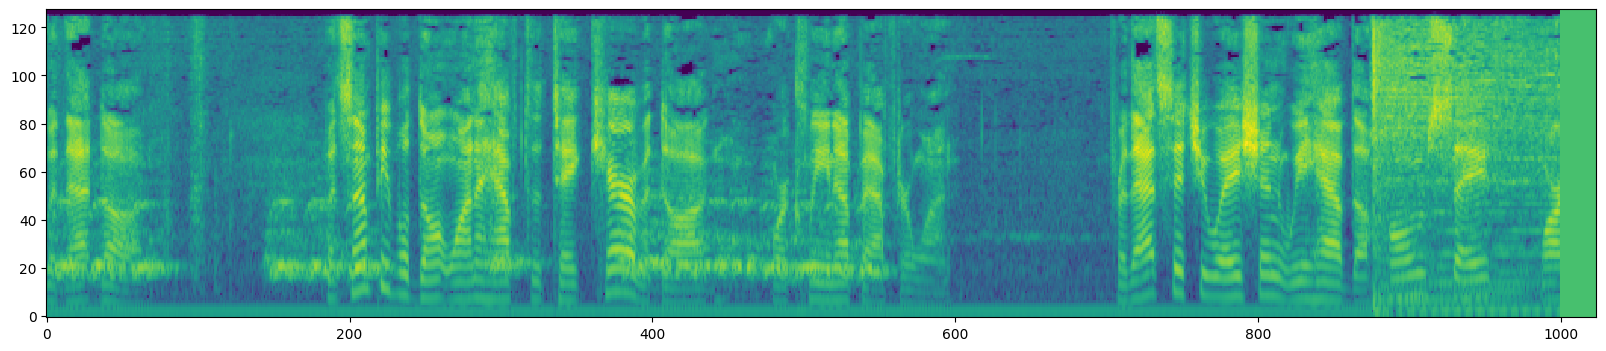

In [129]:
# wav_file = '/mnt/data/tungtran/data/coral_chorus/Cocoloba_rawaudio_split/1678000154.170726000036_chunk_3.wav'
# wav_file= '/mnt/data/tungtran/data/indonesia_hour_long_split/BaF1.1055H.1678278701.180827_chunk_3.wav'
wav_file = 'zye7IPXojSc_30.0-40.0.mp3'
#wav_file='/large_experiments/cmd/audioset/balance_wav/zyqg4pYEioQ.wav'
#wav_file='/large_experiments/cmd/audioset/balance_wav/zxxjPPEujvU.wav'

fbank = wav2fbank(wav_file)
fbank = norm_fbank(fbank)
display_fbank(fbank)

In [130]:
x = torch.tensor(fbank)
print(x.shape)
# make it a batch-like
x = x.unsqueeze(dim=0)
x = x.unsqueeze(dim=0)
print(x.shape)
torch.manual_seed(1)
# run MAE
model.mask_2d=False
model.mask_t_prob=0.5
model.mask_f_prob=0.3
loss, y, mask, _ = model(x.float(), mask_ratio=0.3)
print('y_shape:',y.shape, 'mask_shape',mask.shape)
print(f'mask sum (masked): {mask.sum()}, mask keep: {np.ones_like(mask).sum()-mask.sum()}')
y = model.unpatchify(y)
y = torch.einsum('nchw->nhwc', y).detach().cpu()
print('y_unpatchified.shape:',y.shape)

/tmp/ipykernel_1420137/2643624639.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(fbank)


torch.Size([1024, 128])
torch.Size([1, 1, 1024, 128])
y_shape: torch.Size([1, 512, 256]) mask_shape torch.Size([1, 512])
mask sum (masked): 154.0, mask keep: 358.0
y_unpatchified.shape: torch.Size([1, 1024, 128, 1])


In [131]:
# visualize the mask
mask = mask.detach()
#mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *1)
print(mask.shape)
mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
print(mask.shape)
mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
print(mask.shape)
x = torch.einsum('nchw->nhwc', x)
print('x',x.shape)
# masked image
im_masked = x * (1 - mask) 
# MAE reconstruction pasted with visible patches
im_paste = x * (1 - mask) + y * mask
# im_paste = (y+0.5)*(1 - mask) + y*mask

torch.Size([1, 512, 256])
torch.Size([1, 1, 1024, 128])
torch.Size([1, 1024, 128, 1])
x torch.Size([1, 1024, 128, 1])


In [132]:
minmin = np.min([x[0].min(), im_masked[0].min(), y[0].min(), im_paste[0].min()])
maxmax = np.max([x[0].max(), im_masked[0].max(), y[0].max(), im_paste[0].max()])
minmin *= 10
maxmax *= 1
minmin=-10
maxmax=10
start=200
end=900
print(minmin,maxmax)

-10 10


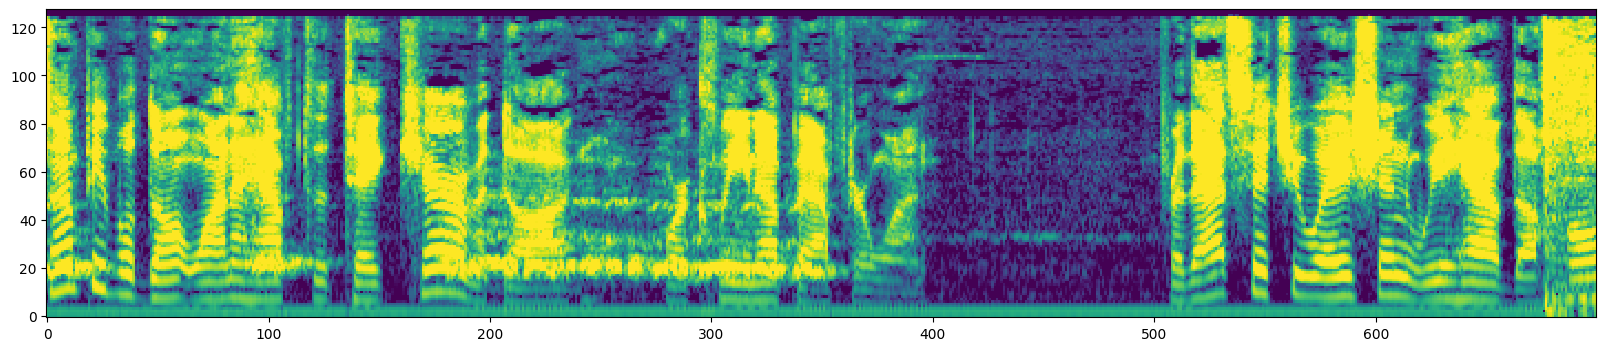

In [133]:
display_fbank(x[0][start:end].squeeze(), minmin=minmin, maxmax=maxmax)

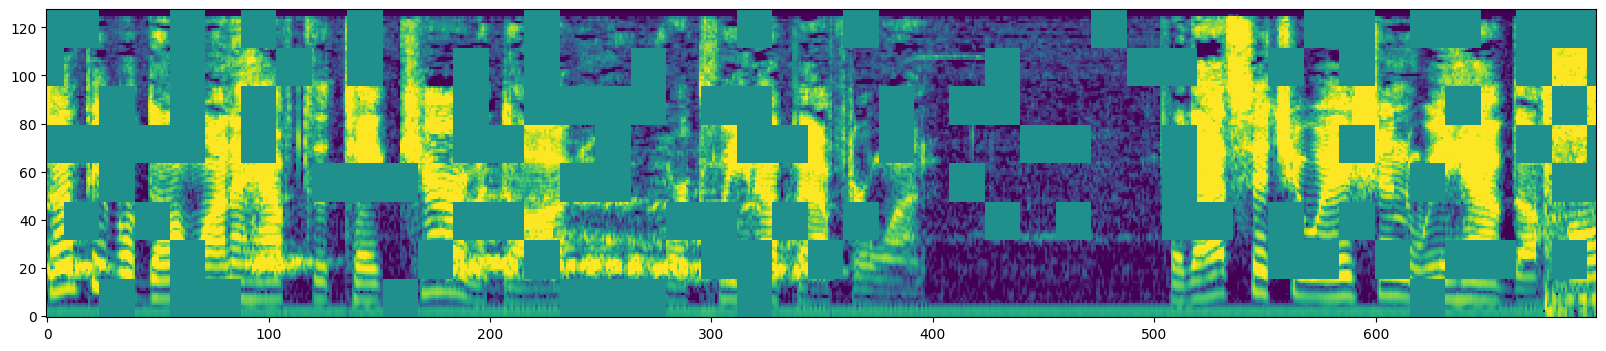

In [134]:
display_fbank(im_masked[0][start:end].squeeze(),minmin=minmin, maxmax=maxmax)

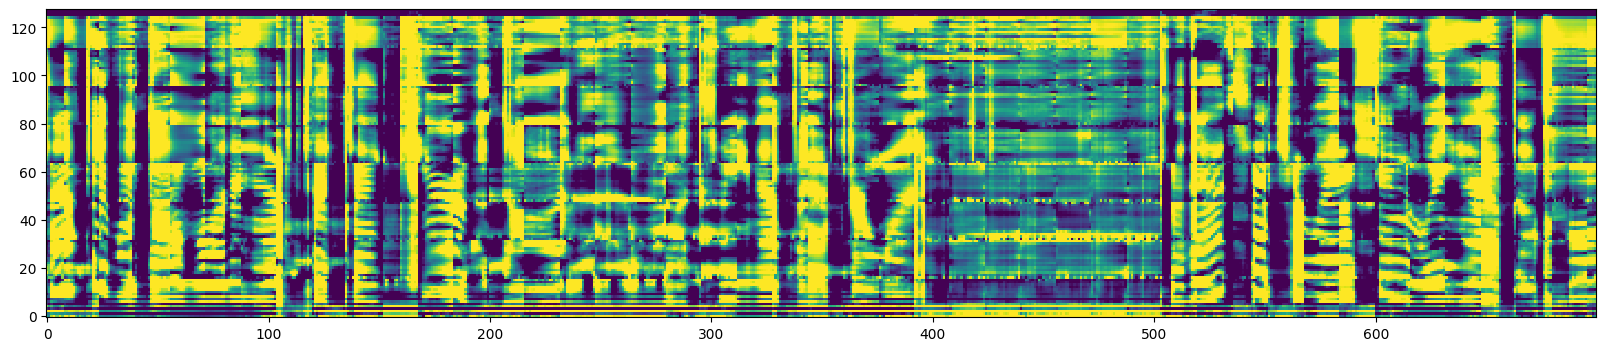

In [135]:
display_fbank((y[0][start:end]).squeeze(), minmin=minmin, maxmax=maxmax)

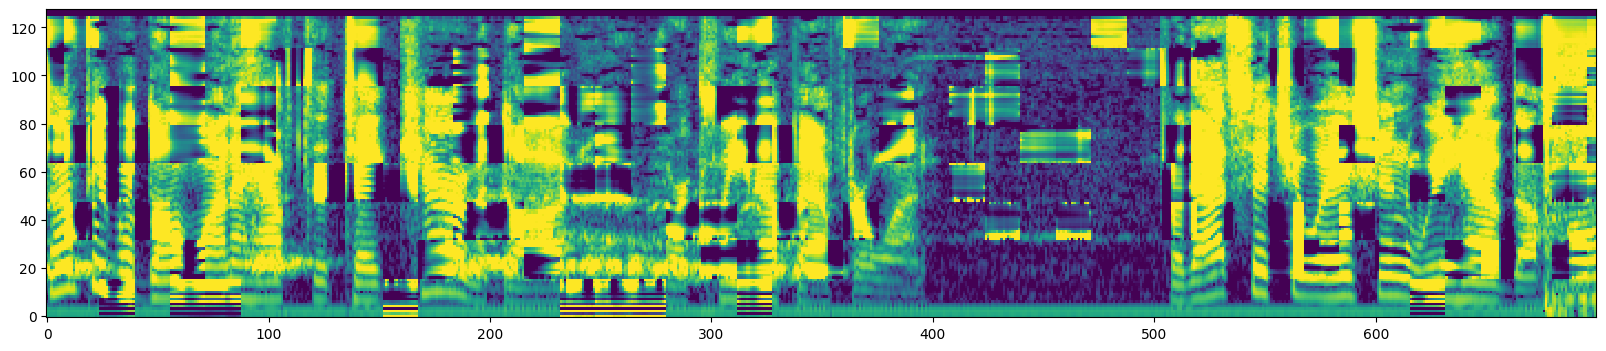

In [136]:
display_fbank(im_paste[0][start:end].squeeze(),minmin=minmin, maxmax=maxmax)

In [612]:
x=range(16)
print(1/np.exp(x)1)

[2.         1.36787944 1.13533528 1.04978707 1.01831564 1.00673795
 1.00247875 1.00091188 1.00033546 1.00012341 1.0000454  1.0000167
 1.00000614 1.00000226 1.00000083 1.00000031]
